# Developing Spark Applications

In Chapter 15, you learned about how Spark runs your code on the cluster. We’ll now show you
how easy it is to develop a standalone Spark application and deploy it on a cluster. We’ll do this
using a simple template that shares some easy tips for how to structure your applications,
including setting up build tools and unit testing. This template is available in the book’s code
repository. This template is not really necessary, because writing applications from scratch isn’t
hard, but it helps. Let’s get started with our first application.

## Writing Spark Applications
Spark Applications are the combination of two things: a Spark cluster and your code. In this
case, the cluster will be local mode and the application will be one that is pre-defined. Let’s walk
through an application in each langauge.
### A Simple Scala-Based App
Scala is Spark’s “native” language and naturally makes for a great way to write applications. It’s really no different than writing a Scala application.

TIP

Scala can seem intimidating, depending on your background, but it’s worth learning if only to
understand Spark just a bit better. Additionally, you do not need to learn all the language’s ins and
outs; begin with the basics and you’ll see that it’s easy to be productive in Scala in no time. Using
Scala will also open up a lot of doors. With a little practice, it’s not to difficult to do code-level tracing
through Spark’s codebase.

You can build applications using sbt or Apache Maven, two Java Virtual Machine (JVM)–based
build tools. As with any build tool, they each have their own quirks, but it’s probably easiest to
begin with sbt. You can download, install, and learn about sbt on the sbt website. You can install
Maven from its respective website, as well.

To configure an sbt build for our Scala application, we specify a build.sbt file to manage the package information. Inside the build.sbt file, there are a few key things to include:
* Project metadata (package name, package versioning information, etc.)
* Where to resolve dependencies
* Dependencies needed for your library
There are many more options that you can specify; however, they are beyond the scope of this
book (you can find information about this on the web and in the sbt documentation). There are
also some books on the subject that can serve as a helpful reference as soon as you’ve gone
beyond anything nontrivial. Here’s what a sample Scala built.sbt file might look like (and the
one that we include in the template). Notice how we must specify the Scala version as well as the
Spark version:
~~~
name := "example"
organization := "com.databricks"
version := "0.1-SNAPSHOT"
scalaVersion := "2.11.8"
// Spark Information
val sparkVersion = "2.2.0"
// allows us to include spark packages
resolvers += "bintray-spark-packages" at
   "https://dl.bintray.com/spark-packages/maven/"
resolvers += "Typesafe Simple Repository" at
   "http://repo.typesafe.com/typesafe/simple/maven-releases/"
resolvers += "MavenRepository" at
   "https://mvnrepository.com/"   
libraryDependencies ++= Seq(
   // spark core
   "org.apache.spark" %% "spark-core" % sparkVersion,
   "org.apache.spark" %% "spark-sql" % sparkVersion,
// the rest of the file is omitted for brevity
)
~~~
Now that we’ve defined the build file, we can actually go about adding code to our project. We’ll
use the standard Scala project structure, which you can find in the sbt reference manual (this is
the same directory structure as Maven projects):
~~~
src/
  main/
    resources/
      <files to include in main jar here>
    scala/
      <main Scala sources>
    java/
      <main Java sources>
  test/
    resources
      <files to include in test jar here>
    scala/
      <test Scala sources>
    java/
      <test Java sources>
~~~
We put the source code in the Scala and Java directories. In this case, we put something like the
following in a file; this initializes the SparkSession, runs the application, and then exits:
~~~
object DataFrameExample extends Serializable {
  def main(args: Array[String]) = {
    val pathToDataFolder = args(0)
    // start up the SparkSession
    // along with explicitly setting a given config
    val spark = SparkSession.builder().appName("Spark Example")
      .config("spark.sql.warehouse.dir", "/user/hive/warehouse")
      .getOrCreate()
    // udf registration
    spark.udf.register("myUDF", someUDF(_:String):String)
    val df = spark.read.json(pathToDataFolder + "data.json")
    val manipulated = df.groupBy(expr("myUDF(group)")).sum().collect()
      .foreach(x => println(x))
  }
}
~~~
Notice how we defined a main class that we can run from the command line when we use
spark-submit to submit it to our cluster for execution.
Now that we have our project set up and have added some code to it, it’s time to build it. We can
use sbt assemble to build an “uber-jar” or “fat-jar” that contains all of the dependencies in one
JAR. This can be simple for some deployments but cause complications (especially dependency
conflicts) for others. A lighter-weight approach is to run sbt package, which will gather all of
your dependencies into the target folder but will not package all of them into one big JAR.

#### Running the application
The target folder contains the JAR that we can use as an argument to spark-submit. After
building the Scala package, you end up with something that you can spark-submit on your
local machine by using the following code (this snippet takes advantage of aliasing to create the $SPARK_HOME variable; you could replace $SPARK_HOME with the exact directory that contains your downloaded version of Spark):
~~~
$SPARK_HOME/bin/spark-submit \
  --class com.databricks.example.DataFrameExample \
  --master local \
  target/scala-2.11/example_2.11-0.1-SNAPSHOT.jar "hello"
~~~

## Writing Python Applications
Writing PySpark Applications is really no different than writing normal Python applications or
packages. It’s quite similar to writing command-line applications in particular. Spark doesn’t
have a build concept, just Python scripts, so to run an application, you simply execute the script
against the cluster.
To facilitate code reuse, it is common to package multiple Python files into egg or ZIP files of
Spark code. To include those files, you can use the --py-files argument of spark-submit to
add .py, .zip, or .egg files to be distributed with your application.
When it’s time to run your code, you create the equivalent of a “Scala/Java main class” in
Python. Specify a certain script as an executable script that builds the SparkSession. This is the
one that we will pass as the main argument to spark-submit:
~~~
# in Python
from __future__ import print_function
if __name__ == '__main__':
    from pyspark.sql import SparkSession
    spark = SparkSession.builder \
        .master("local") \
        .appName("Word Count") \
        .config("spark.some.config.option", "some-value") \
        .getOrCreate()
    print(spark.range(5000).where("id > 500").selectExpr("sum(id)").collect())
~~~
When you do this, you’re going to get a SparkSession that you can pass around your
application. It is best practice to pass around this variable at runtime rather than instantiating it
within every Python class.
One helpful tip when developing in Python is to use pip to specify PySpark as a dependency.
You can do this by running the command pip install pyspark. This allows you to use it in a
way that you might use other Python packages. This makes for very helpful code completion in
many editors, as well. This is brand new in Spark 2.2, so it might take a version or two to be
completely production ready, but Python is very popular in the Spark community, and it’s sure to
be a cornerstone of Spark’s future.

#### Running the application
After you’ve written your code, it’s time to submit it for execution. (We’re executing the same
code that we have in the project template.) You just need to call spark-submit with that
information:

$SPARK_HOME/bin/spark-submit --master local pyspark_template/main.py

In [1]:
from __future__ import print_function
from pyspark.sql import SparkSession
spark = (SparkSession.builder
         .master("local")
         .appName("Word Count")
         .config("spark.some.config.option", "some-value")
         .getOrCreate())
print(spark.range(5000).where("id > 500").selectExpr("sum(id)").collect())

[Row(sum(id)=12372250)]


## Writing Java Applications
Writing Java Spark Applications is, if you squint, the same as writing Scala applications. The
core differences involve how you specify your dependencies.
This example assumes that you are using Maven to specify your dependencies. In this case,
you’ll use the following format. In Maven, you must add the Spark Packages repository so that
you can fetch dependencies from those locations:
~~~
<dependencies>
<dependency>
<groupId>org.apache.spark</groupId>
<artifactId>spark-core_2.11</artifactId>
<version>2.1.0</version>
</dependency>
<dependency>
<groupId>org.apache.spark</groupId>
<artifactId>spark-sql_2.11</artifactId>
<version>2.1.0</version>
</dependency>
<dependency>
<groupId>graphframes</groupId>
<artifactId>graphframes</artifactId>
<version>0.4.0-spark2.1-s_2.11</version>
</dependency>
</dependencies>
<repositories>
<!-- list of other repositories -->
<repository>
<id>SparkPackagesRepo</id>
<url>http://dl.bintray.com/spark-packages/maven</url>
</repository>
</repositories>
~~~
Naturally, you follow the same directory structure as in the Scala project version (seeing as they
both conform to the Maven specification). We then just follow the relevant Java examples to
actually build and execute the code. Now we can create a simple example that specifies a main
class for us to execute against (more on this at the end of the chapter):
~~~
import org.apache.spark.sql.SparkSession;
public class SimpleExample {
public static void main(String[] args) {
SparkSession spark = SparkSession
.builder()
.getOrCreate();
spark.range(1, 2000).count();
}
}
~~~
We then package it by using mvn package (you need to have Maven installed to do so).
Running the application
This operation is going to be the exact same as running the Scala application (or the Python
application, for that matter). Simply use spark-submit:

$SPARK_HOME/bin/spark-submit \
    --class com.databricks.example.SimpleExample \
    --master local \
    target/spark-example-0.1-SNAPSHOT.jar "hello"

## Testing Spark Applications
You now know what it takes to write and run a Spark Application, so let’s move on to a less
exciting but still very important topic: testing. Testing Spark Applications relies on a couple of
key principles and tactics that you should keep in mind as you’re writing your applications.
Strategic Principles
Testing your data pipelines and Spark Applications is just as important as actually writing them.
This is because you want to ensure that they are resilient to future change, in data, logic, and
output. In this section, we’ll first discuss what you might want to test in a typical Spark
Application, then discuss how to organize your code for easy testing.
#### Input data resilience
Being resilient to different kinds of input data is something that is quite fundamental to how you
write your data pipelines. The data will change because the business needs will change.
Therefore your Spark Applications and pipelines should be resilient to at least some degree of
change in the input data or otherwise ensure that these failures are handled in a graceful and
resilient way. For the most part this means being smart about writing your tests to handle those
edge cases of different inputs and making sure that the pager only goes off when it’s something
that is truly important.
#### Business logic resilience and evolution
The business logic in your pipelines will likely change as well as the input data. Even more
importantly, you want to be sure that what you’re deducing from the raw data is what you
actually think that you’re deducing. This means that you’ll need to do robust logical testing with
realistic data to ensure that you’re actually getting what you want out of it. One thing to be wary
of here is trying to write a bunch of “Spark Unit Tests” that just test Spark’s functionality. You
don’t want to be doing that; instead, you want to be testing your business logic and ensuring that
the complex business pipeline that you set up is actually doing what you think it should be doing.
#### Resilience in output and atomicity
Assuming that you’re prepared for departures in the structure of input data and that your business
logic is well tested, you now want to ensure that your output structure is what you expect. This
means you will need to gracefully handle output schema resolution. It’s not often that data is simply dumped in some location, never to be read again—most of your Spark pipelines are
probably feeding other Spark pipelines. For this reason you’re going to want to make certain that
your downstream consumers understand the “state” of the data—this could mean how frequently
it’s updated as well as whether the data is “complete” (e.g., there is no late data) or that there
won’t be any last-minute corrections to the data.
All of the aforementioned issues are principles that you should be thinking about as you build
your data pipelines (actually, regardless of whether you’re using Spark). This strategic thinking
is important for laying down the foundation for the system that you would like to build.

## Tactical Takeaways
Although strategic thinking is important, let’s talk a bit more in detail about some of the tactics
that you can actually use to make your application easy to test. The highest value approach is to
verify that your business logic is correct by employing proper unit testing and to ensure that
you’re resilient to changing input data or have structured it so that schema evolution will not
become unwielding in the future. The decision for how to do this largely falls on you as the
developer because it will vary according to your business domain and domain expertise.
#### Managing SparkSessions
Testing your Spark code using a unit test framework like JUnit or ScalaTest is relatively easy
because of Spark’s local mode—just create a local mode SparkSession as part of your test
harness to run it. However, to make this work well, you should try to perform dependency
injection as much as possible when managing SparkSessions in your code. That is, initialize the
SparkSession only once and pass it around to relevant functions and classes at runtime in a way
that makes it easy to substitute during testing. This makes it much easier to test each individual
function with a dummy SparkSession in unit tests.
#### Which Spark API to Use?
Spark offers several choices of APIs, ranging from SQL to DataFrames and Datasets, and each
of these can have different impacts for maintainability and testability of your application. To be
perfectly honest, the right API depends on your team and its needs: some teams and projects will
need the less strict SQL and DataFrame APIs for speed of development, while others will want
to use type-safe Datasets or RDDs.
In general, we recommend documenting and testing the input and output types of each function
regardless of which API you use. The type-safe API automatically enforces a minimal contract
for your function that makes it easy for other code to build on it. If your team prefers to use
DataFrames or SQL, then spend some time to document and test what each function returns and
what types of inputs it accepts to avoid surprises later, as in any dynamically typed programming
language. While the lower-level RDD API is also statically typed, we recommend going into it
only if you need low-level features such as partitioning that are not present in Datasets, which
should not be very common; the Dataset API allows more performance optimizations and is
likely to provide even more of them in the future.
A similar set of considerations applies to which programming language to use for your
application: there certainly is no right answer for every team, but depending on your needs, each
language will provide different benefits. We generally recommend using statically typed
languages like Scala and Java for larger applications or those where you want to be able to drop
into low-level code to fully control performance, but Python and R may be significantly better in
other cases—for example, if you need to use some of their other libraries. Spark code should
easily be testable in the standard unit testing frameworks in every language.

## Connecting to Unit Testing Frameworks
To unit test your code, we recommend using the standard frameworks in your langage (e.g.,
JUnit or ScalaTest), and setting up your test harnesses to create and clean up a SparkSession for
each test. Different frameworks offer different mechanisms to do this, such as “before” and
“after” methods. We have included some sample unit testing code in the application templates
for this chapter.
## Connecting to Data Sources
As much as possible, you should make sure your testing code does not connect to production
data sources, so that developers can easily run it in isolation if these data sources change. One
easy way to make this happen is to have all your business logic functions take DataFrames or
Datasets as input instead of directly connecting to various sources; after all, subsequent code will
work the same way no matter what the data source was. If you are using the structured APIs in
Spark, another way to make this happen is named tables: you can simply register some dummy
datasets (e.g., loaded from small text file or from in-memory objects) as various table names and
go from there.

## The Development Process
The development process with Spark Applications is similar to development workflows that you
have probably already used. First, you might maintain a scratch space, such as an interactive
notebook or some equivalent thereof, and then as you build key components and algorithms, you
move them to a more permanent location like a library or package. The notebook experience is
one that we often recommend (and are using to write this book) because of its simplicity in
experimentation. There are also some tools, such as Databricks, that allow you to run notebooks
as production applications as well.
When running on your local machine, the spark-shell and its various language-specific
implementations are probably the best way to develop applications. For the most part, the shell is
for interactive applications, whereas spark-submit is for production applications on your Spark
cluster. You can use the shell to interactively run Spark, just as we showed you at the beginning
of this book. This is the mode with which you will run PySpark, Spark SQL, and SparkR. In the
bin folder, when you download Spark, you will find the various ways of starting these shells.

Simply run spark-shell(for Scala), spark-sql, pyspark, and sparkR.

After you’ve finished your application and created a package or script to run, spark-submit will
become your best friend to submit this job to a cluster.

Launching Applications
The most common way for running Spark Applications is through spark-submit. Previously in
this chapter, we showed you how to run spark-submit; you simply specify your options, the
application JAR or script, and the relevant arguments:
~~~
./bin/spark-submit \
--class <main-class> \
--master <master-url> \
--deploy-mode <deploy-mode> \
--conf <key>=<value> \
... # other options
<application-jar-or-script> \
[application-arguments]
~~~
You can always specify whether to run in client or cluster mode when you submit a Spark job
with spark-submit. However, you should almost always favor running in cluster mode (or in
client mode on the cluster itself) to reduce latency between the executors and the driver.

When submitting applciations, pass a .py file in the place of a .jar, and add Python .zip, .egg,
or .py to the search path with --py-files.

For reference, Table 16-1 lists all of the available spark-submit options, including those that
are particular to some cluster managers. To enumerate all these options yourself, run sparksubmit with --help.
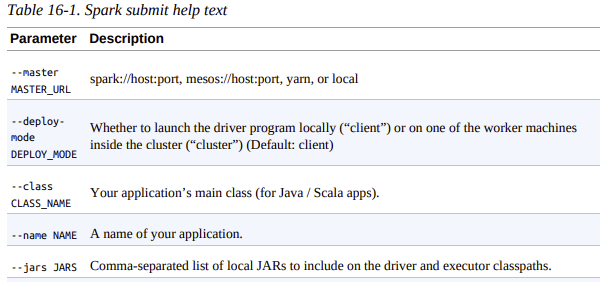
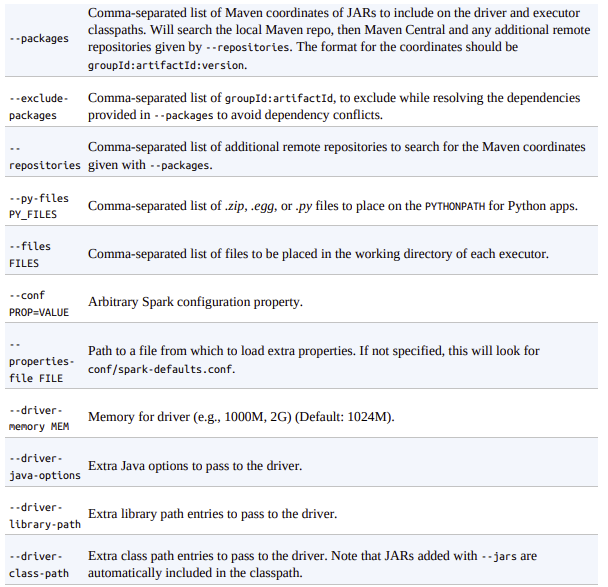
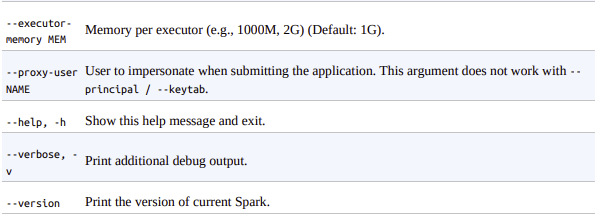
There are some deployment-specific configurations as well (see Table 16-2)
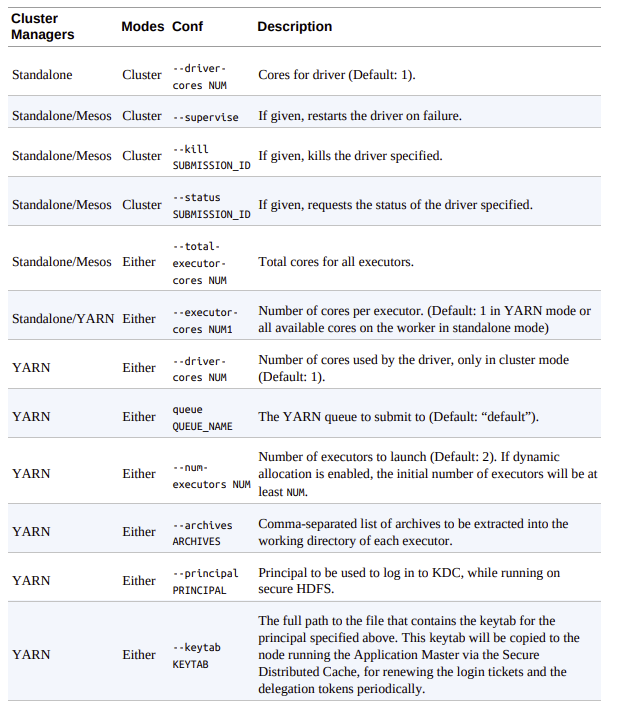

## Application Launch Examples
We already covered some local-mode application examples previously in this chapter, but it’s
worth looking at how we use some of the aforementioned options, as well. Spark also includes
several examples and demonstration applications in the examples directory that is included when
you download Spark. If you’re stuck on how to use certain parameters, simply try them first on
your local machine and use the SparkPi class as the main class:
~~~
./bin/spark-submit \
  --class org.apache.spark.examples.SparkPi \
  --master spark://207.184.161.138:7077 \
  --executor-memory 20G \
  --total-executor-cores 100 \
  replace/with/path/to/examples.jar \
  1000
  ~~~
The following snippet does the same for Python. You run it from the Spark directory and this
will allow you to submit a Python application (all in one script) to the standalone cluster
manager. You can also set the same executor limits as in the preceding example:
~~~
./bin/spark-submit \
  --master spark://207.184.161.138:7077 \
  examples/src/main/python/pi.py \
  1000
  ~~~
You can change this to run in local mode as well by setting the master to local or local[*] to
run on all the cores on your machine. You will also need to change the /path/to/examples.jar
to the relevant Scala and Spark versions you are running.

## Configuring Applications
Spark includes a number of different configurations, some of which we covered in Chapter 15.
There are many different configurations, depending on what you’re hoping to achieve. This
section covers those very details. For the most part, this information is included for reference and
is probably worth skimming only, unless you’re looking for something in particular. The
majority of configurations fall into the following categories:
* Application properties
* Runtime environment
* Shuffle behavior
* Spark UI
* Compression and serialization
* Memory management
* Execution behavior
* Networking
* Scheduling
* Dynamic allocation
* Security
* Encryption
* Spark SQL
* Spark streaming
* SparkR

Spark provides three locations to configure the system:
* Spark properties control most application parameters and can be set by using a
SparkConf object
* Java system properties
* Hardcoded configuration files

There are several templates that you can use, which you can find in the /conf directory available
in the root of the Spark home folder. You can set these properties as hardcoded variables in your
applications or by specifying them at runtime. You can use environment variables to set permachine settings, such as the IP address, through the conf/spark-env.sh script on each node.
Lastly, you can configure logging through log4j.properties.

## The SparkConf
The SparkConf manages all of our application configurations. You create one via the import
statement, as shown in the example that follows. After you create it, the SparkConf is immutable
for that specific Spark Application:
~~~
// in Scala
import org.apache.spark.SparkConf
val conf = new SparkConf().setMaster("local[2]").setAppName("DefinitiveGuide")
  .set("some.conf", "to.some.value")
# in Python
from pyspark import SparkConf
conf = SparkConf().setMaster("local[2]").setAppName("DefinitiveGuide")\
  .set("some.conf", "to.some.value")
  ~~~
You use the SparkConf to configure individual Spark Applications with Spark properties. These
Spark properties control how the Spark Application runs and how the cluster is configured. The
example that follows configures the local cluster to have two threads and specifies the
application name that shows up in the Spark UI.
You can configure these at runtime, as you saw previously in this chapter through command-line
arguments. This is helpful when starting a Spark Shell that will automatically include a basic
Spark Application for you; for instance:

./bin/spark-submit --name "DefinitiveGuide" --master local[4] ...

Of note is that when setting time duration-based properties, you should use the following format:
* 25ms (milliseconds)
* 5s (seconds)
* 10m or 10min (minutes)
* 3h (hours)
* 5d (days)
* 1y (years)

## Application Properties
Application properties are those that you set either from spark-submit or when you create your
Spark Application. They define basic application metadata as well as some execution
characteristics. Table 16-3 presents a list of current application properties.
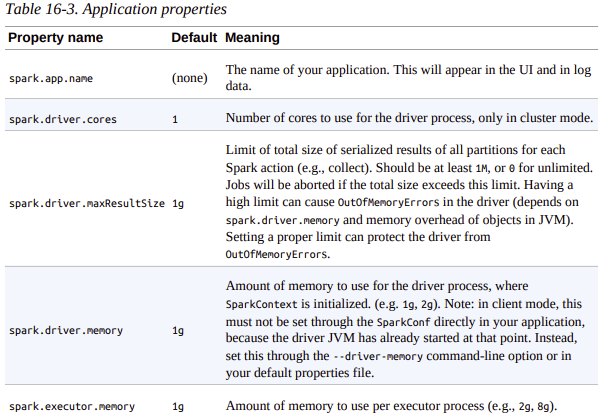
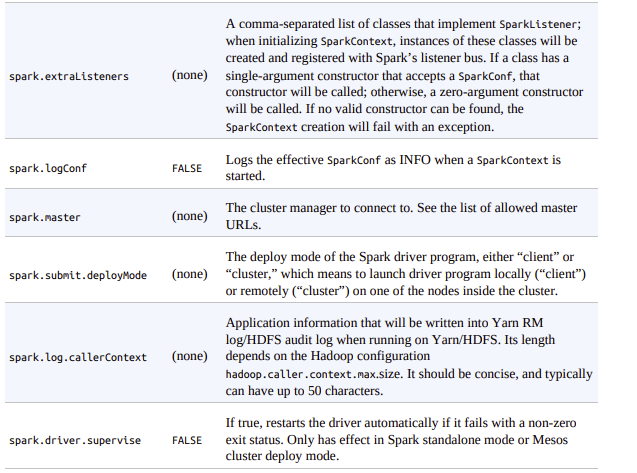
You can ensure that you’ve correctly set these values by checking the application’s web UI on
port 4040 of the driver on the “Environment” tab. Only values explicitly specified through sparkdefaults.conf, SparkConf, or the command line will appear. For all other configuration
properties, you can assume the default value is used.

## Runtime Properties
Although less common, there are times when you might also need to configure the runtime
environment of your application. Due to space limitations, we cannot include the entire
configuration set here. Refer to the relevant table on the Runtime Environment in the Spark
documentation. These properties allow you to configure extra classpaths and python paths for
both drivers and executors, Python worker configurations, as well as miscellaneous logging
properties.

## Execution Properties
These configurations are some of the most relevant for you to configure because they give you
finer-grained control on actual execution. Due to space limitations, we cannot include the entire
configuration set here. Refer to the relevant table on Execution Behavior in the Spark
documentation. The most common configurations to change are spark.executor.cores (to
control the number of available cores) and spark.files.maxPartitionBytes (maximum
partition size when reading files).

## Configuring Memory Management
There are times when you might need to manually manage the memory options to try and
optimize your applications. Many of these are not particularly relevant for end users because
they involve a lot of legacy concepts or fine-grained controls that were obviated in Spark 2.X
because of automatic memory management. Due to space limitations, we cannot include the
entire configuration set here. Refer to the relevant table on Memory Management in the Spark
documentation.
## Configuring Shuffle Behavior
We’ve emphasized how shuffles can be a bottleneck in Spark jobs because of their high
communication overhead. Therefore there are a number of low-level configurations for
controlling shuffle behavior. Due to space limitations, we cannot include the entire configuration
set here. Refer to the relevant table on Shuffle Behavior in the Spark documentation.
## Environmental Variables
You can configure certain Spark settings through environment variables, which are read from the
conf/spark-env.sh script in the directory where Spark is installed (or conf/spark-env.cmd on
Windows). In Standalone and Mesos modes, this file can give machine-specific information such
as hostnames. It is also sourced when running local Spark Applications or submission scripts.

Note that conf/spark-env.sh does not exist by default when Spark is installed. However, you can
copy conf/spark-env.sh.template to create it. Be sure to make the copy executable.

The following variables can be set in spark-env.sh:

___JAVA_HOME___

Location where Java is installed (if it’s not on your default PATH).

___PYSPARK_PYTHON___

Python binary executable to use for PySpark in both driver and workers (default is
python2.7 if available; otherwise, python). Property spark.pyspark.python takes
precedence if it is set.

___PYSPARK_DRIVER_PYTHON___

Python binary executable to use for PySpark in driver only (default is PYSPARK_PYTHON).
Property spark.pyspark.driver.python takes precedence if it is set.

___SPARKR_DRIVER_R___

R binary executable to use for SparkR shell (default is R). Property
spark.r.shell.command takes precedence if it is set.

___SPARK_LOCAL_IP___

IP address of the machine to which to bind.

___SPARK_PUBLIC_DNS___

Hostname your Spark program will advertise to other machines.

In addition to the variables ust listed, there are also options for setting up the Spark standalone
cluster scripts, such as number of cores to use on each machine and maximum memory. Because
spark-env.sh is a shell script, you can set some of these programmatically; for example, you
might compute SPARK_LOCAL_IP by looking up the IP of a specific network interface.

___NOTE___

When running Spark on YARN in cluster mode, you need to set environment variables by using the
spark.yarn.appMasterEnv.[EnvironmentVariableName] property in your conf/spark-defaults.conf
file. Environment variables that are set in spark-env.sh will not be reflected in the YARN Application
Master process in cluster mode. See the YARN-related Spark Properties for more information.

## Job Scheduling Within an Application
Within a given Spark Application, multiple parallel jobs can run simultaneously if they were
submitted from separate threads. By job, in this section, we mean a Spark action and any tasks
that need to run to evaluate that action. Spark’s scheduler is fully thread-safe and supports this
use case to enable applications that serve multiple requests (e.g., queries for multiple users).
By default, Spark’s scheduler runs jobs in FIFO fashion. If the jobs at the head of the queue
don’t need to use the entire cluster, later jobs can begin to run right away, but if the jobs at the
head of the queue are large, later jobs might be delayed significantly.
It is also possible to configure fair sharing between jobs. Under fair sharing, Spark assigns tasks
between jobs in a round-robin fashion so that all jobs get a roughly equal share of cluster
resources. This means that short jobs submitted while a long job is running can begin receiving
resources right away and still achieve good response times without waiting for the long job to
finish. This mode is best for multiuser settings.
To enable the fair scheduler, set the spark.scheduler.mode property to FAIR when configuring
a SparkContext.
The fair scheduler also supports grouping jobs into pools, and setting different scheduling
options, or weights, for each pool. This can be useful to create a high-priority pool for more
important jobs or to group the jobs of each user together and give users equal shares regardless
of how many concurrent jobs they have instead of giving jobs equal shares. This approach is
modeled after the Hadoop Fair Scheduler.
Without any intervention, newly submitted jobs go into a default pool, but jobs pools can be set
by adding the spark.scheduler.pool local property to the SparkContext in the thread that’s
submitting them. This is done as follows (assuming sc is your SparkContext:

sc.setLocalProperty("spark.scheduler.pool", "pool1")

After setting this local property, all jobs submitted within this thread will use this pool name. The
setting is per-thread to make it easy to have a thread run multiple jobs on behalf of the same user.
If you’d like to clear the pool that a thread is associated with, set it to null.

## Conclusion
This chapter covered a lot about Spark Applications; we learned how to write, test, run, and
configure them in all of Spark’s languages. In Chapter 17, we talk about deploying and the
cluster management options you have when it comes to running Spark Applications.